# Main Diffusion Script
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
import optuna, plotly
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances

# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.0/430.0 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 99.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 68.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

### Config

General

In [2]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_wave_v2"
training_data_name: str = "training_full_wave"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [3]:
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [4]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 1400
n_validation_samples: int = 50
tensor_dim: list = [1, 1, 2**17] #B, C, H = Batch, channels, Time domain

batch_size: int = 2


learning_rate: float = 0.0006368175660985065
betas: tuple[float] = (0.63, 0.69)
epochs: int = 1000
restart_training: bool = True
checkpoint_freq: int = 10

### Data Loading

In [5]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
np.random.seed(50)
np.random.shuffle(file)
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-06-22 18:20:42,771 - LIGHT_DEBUG - Ndarray loaded from Data/training_full_wave.npy of shape: (6867, 131072)
2025-06-22 18:20:44,073 - INFO - Data loaded with shape: (6867, 131072)


### Setup

Model Creation

Optuna

In [14]:
def net(trial: optuna.Trial) -> nn.Module:
    base_chan = trial.suggest_int("starting_channels", 64, 256, step=16)
    s_l_attn = trial.suggest_int("attn_start", 3, 6, step=1)
    u_net = LTPlugin(UNetV0, num_filters=128, window_length=64, stride=64)
    u_net = DiffusionModel(
        net_t=u_net,
        in_channels=1,
        channels=[base_chan, base_chan, base_chan * 2, base_chan * 2, base_chan * 4, base_chan * 4],
        factors=[1, 2, 2, 2, 2, 2],
        items=[2, 2, 2, 2, 4, 4],
        attentions=[int(i >= s_l_attn) for i in range(6)],
        attention_features=64,
        attention_heads=12,
        diffusion_t=VDiffusion,
        sampler_t=VSampler,
        dim=1
    ).to(device)
    return u_net

def objective(trial: optuna.Trial) -> float:
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_int("batch_size", 2, 16, step=2)
    b1 = trial.suggest_float("b1", 0.4, 0.99)
    b2 = trial.suggest_float("b2", 0.4, 0.999)
    model = net(trial).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(b1, b2))
    
    data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
    validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
    
    n_epochs = 20
    if device == "cuda":
        scaler = torch.cuda.amp.GradScaler()
    else:
        scaler = torch.amp.GradScaler(device=device)

    best_val_loss: float = float('inf')
    for e in range(n_epochs):
        total_loss: float = 0
        validation_loss: float = 0

        for b_idx, (x, _) in enumerate(data_loader):
            if x.dim() == 2:
                x = x.to(device).unsqueeze(1)
            else:
                x = x.to(device)
            with torch.autocast(device_type=device):
                loss = model(x)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            if np.isnan(loss.item()):
                raise optuna.TrialPruned()

        if validation_dataloader is not None:
            model.eval()
            for (x, _) in validation_dataloader:
                if x.dim() == 2:
                    x = x.to(device).unsqueeze(1)
                else:
                    x = x.to(device)
                with torch.no_grad():
                    loss = model(x)
                    validation_loss += loss.item()
            validation_loss /= len(validation_dataloader)
            model.train()

        total_loss /= len(data_loader)
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
        trial.report(validation_loss, e)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return best_val_loss

def run_optim(n_trials: int, name: str ="main_study_wave") -> None:
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(),study_name=name)
    study.optimize(objective, n_trials=n_trials)
    logger.info("Finished Study")
    logger.info(f"Best trial: {study.best_trial} with value: {study.best_trial.value} using params:")
    for key, val in study.best_trial.params.items():
        logger.info(f"{key}:{val}")
    
    logger.info("Param importance:")
    for param, importance in get_param_importances(study).items():
            logger.info(f"{param}: {importance:.4f}")
    fig = plot_param_importances(study)
    fig.show()


In [ ]:
run_optim(n_trials=50)

[I 2025-06-22 11:35:40,149] A new study created in memory with name: main_study_wave
[I 2025-06-22 11:45:46,951] Trial 0 finished with value: 0.0833039457599322 and parameters: {'lr': 1.0724572472507955e-05, 'batch_size': 6, 'b1': 0.6138944754520306, 'b2': 0.5422113185842037, 'starting_channels': 192, 'attn_start': 4}. Best is trial 0 with value: 0.0833039457599322.
[I 2025-06-22 11:50:03,832] Trial 1 finished with value: 0.12897160202264785 and parameters: {'lr': 1.4723577343003826e-05, 'batch_size': 12, 'b1': 0.4801738869709884, 'b2': 0.8372589458390147, 'starting_channels': 208, 'attn_start': 6}. Best is trial 0 with value: 0.0833039457599322.
[I 2025-06-22 12:18:39,246] Trial 2 finished with value: 0.06731489777565003 and parameters: {'lr': 9.799405155376143e-05, 'batch_size': 2, 'b1': 0.5768117605073024, 'b2': 0.800783004015273, 'starting_channels': 64, 'attn_start': 3}. Best is trial 2 with value: 0.06731489777565003.
[I 2025-06-22 12:24:19,650] Trial 3 finished with value: 0.072

In [6]:
u_net = LTPlugin(UNetV0, num_filters=128, window_length=64, stride=64)
u_net = DiffusionModel(
    net_t=u_net,
    in_channels=1,
    channels=[128, 128, 256, 256, 512, 512],
    factors=[1, 2, 2, 2, 2, 2],
    items=[2, 2, 2, 2, 4, 4],
    attentions=[0, 0, 0, 0, 0, 1],
    attention_features=64,
    attention_heads=12,
    diffusion_t=VDiffusion,
    sampler_t=VSampler,
    dim=1
).to(device)



Model Loading

In [14]:
optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-06-22 18:39:08,642 - INFO - Model diffusion_wave_v2 loaded with ~70.23M Parameters


Initiate Trainer

In [15]:
trainer = Trainer(u_net, optimizer, scheduler, device, n_dims=1)

### Training

2025-06-22 18:48:10,291 - INFO - Training started on cuda


2025-06-22 18:48:10,000 - LIGHT_DEBUG - Batch 002/700 Loss: 0.049 Min/Max params: -3.425, 2.706

2025-06-22 18:48:10,710 - INFO - Breaking due to NaN loss.
2025-06-22 18:48:11,749 - LIGHT_DEBUG - Saved model to Models/diffusion_wave_v2.pth
2025-06-22 18:48:11,750 - LIGHT_DEBUG - Models/diffusion_wave_v2_epoch_000.pth could not be deleted


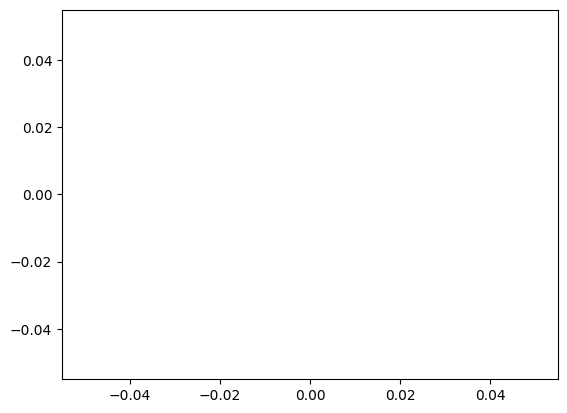

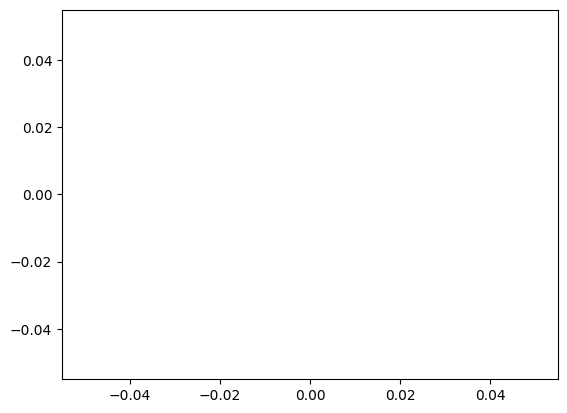

In [17]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=500,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=0.8,
            gradient_clip_val=None,
            sample_freq=None,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)

Save Model Architecture

In [ ]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

RuntimeError: Given groups=1, weight of size [128, 96, 1], expected input[64, 1, 131072] to have 96 channels, but got 1 channels instead

### Sample

In [10]:
samples = trainer.sample(8, tensor_dim, 10, False).reshape(8,2**17)
print(samples.shape)

2025-06-22 18:36:55,982 - LIGHT_DEBUG - Normalized to range: [-1,1]


(8, 131072)


2025-06-22 18:38:47,580 - LIGHT_DEBUG - Started Mel-Spec
2025-06-22 18:38:47,589 - LIGHT_DEBUG - Created mel-spectrogram: (96, 512)


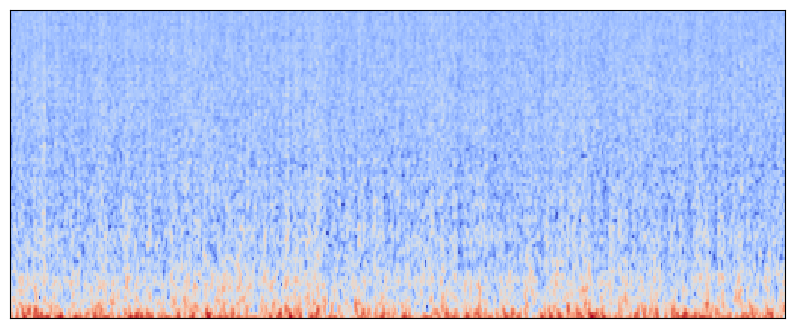

In [13]:
visualize_spectrogram(audio_to_mel_spectrogram(samples[1], 1023, 256, 32000, n_mels=96))

In [ ]:
for i in range(samples.shape[0] -5):
    save_audio_file(samples[i], "test_v2_wave_{}.wav".format(i), sr

2025-06-22 18:37:10,995 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-22 18:37:11,010 - LIGHT_DEBUG - Saved file to:test_v2_wave_0.wav
2025-06-22 18:37:11,011 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-22 18:37:11,033 - LIGHT_DEBUG - Saved file to:test_v2_wave_1.wav
2025-06-22 18:37:11,034 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-06-22 18:37:11,044 - LIGHT_DEBUG - Saved file to:test_v2_wave_2.wav


In [ ]:
save_spectrogram(samples[0], "spect")

Save Samples

In [ ]:
trainer.save_samples(samples, path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result"), remote_kernel))

Evaluate

In [ ]:
trainer.get_audio_metrics(samples, file)

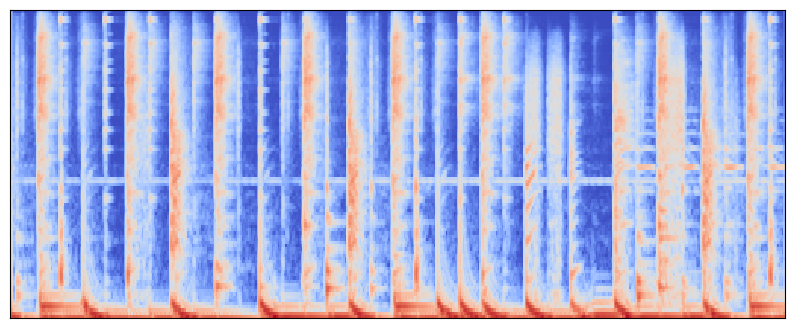

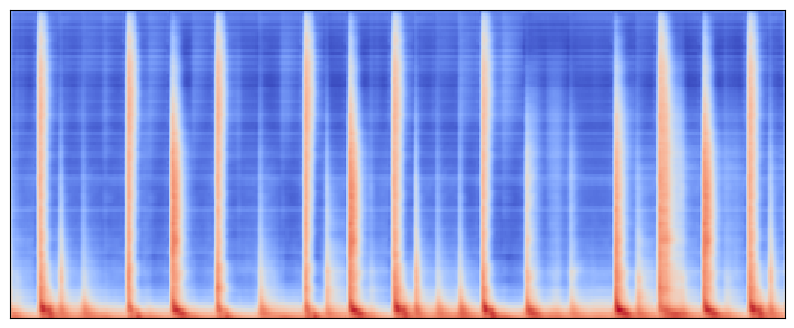

In [ ]:
visualize_spectrogram(file[100], sr=32000)
save_audio_file(librosa.feature.inverse.mel_to_audio(file[100], n_fft=1023, hop_length=256, sr=32000), "test_inference_orig.wav", sr=32000)
out = u_net.sample(torch.tensor(file[100]).unsqueeze(0).to(device), num_steps=1000).cpu().numpy()[0]
visualize_spectrogram(out, sr=32000)
save_audio_file(librosa.feature.inverse.mel_to_audio(out, n_fft=1023, hop_length=256, sr=32000), "test_inference.wav", sr=32000)